In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
from pathlib import Path 

%matplotlib inline


In [4]:
import os
os.chdir("/content/gdrive/My Drive/dataset_adni/augmented_data")

In [ ]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
from pathlib import Path 

%matplotlib inline


In [11]:
pip install keras.utils

  Created wheel for keras.utils: filename=keras_utils-1.0.13-cp37-none-any.whl size=2657 sha256=308963acb974e87f000101323df3739d07511d3b11145efc8f7f5d6bff4f9a37
  Stored in directory: /root/.cache/pip/wheels/46/25/27/7707005c1cb27e1ffc8277b004ac295e34767b02b44d73d6be
Successfully built keras.utils


In [2]:
def load_data(dir_list):
    """
    Read images, resize and normalize them. 
    """
    # load all images in a directory
    X = []
    y = []
    #image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory): 
            # load the image
            image = cv2.imread(directory+'//'+filename)
            # crop the brain and ignore the unnecessary rest part of the image
            #image = crop_brain_contour(image, plot=False)
            # resize image
            #image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-7:] == 'AD_crop':#directory[-6:]
                y.append([2])
            elif directory[-7:] =='MI_crop':
                y.append([1])
            else:
                y.append([3])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y


In [3]:
#IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data(['MI_crop','CN_crop','AD_crop'])


Number of examples is: 2934
X shape is: (2934, 224, 224, 3)
y shape is: (2934, 1)


In [4]:

from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

In [5]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test


In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [7]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))


number of training examples = 2053
number of development examples = 441
number of test examples = 440
X_train shape: (2053, 224, 224, 3)
Y_train shape: (2053, 1)
X_val (dev) shape: (441, 224, 224, 3)
Y_val (dev) shape: (441, 1)
X_test shape: (440, 224, 224, 3)
Y_test shape: (440, 1)


In [8]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"



In [9]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    
    return score


In [13]:

model=Sequential()

#1 conv layer
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(224,224,3)))

#1 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#2 conv layer
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

#2 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#3 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#4 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#5 conv layer
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#3 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())


model.add(Flatten())

#1 dense layer
model.add(Dense(4096,input_shape=(224,224,3),activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#2 dense layer
model.add(Dense(4096,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#3 dense layer
model.add(Dense(1000,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#output layer
model.add(Dense(4,activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 26, 26, 96)        384       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 256)       614656    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 256)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 10, 256)       1024      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 384)        

In [14]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])






In [13]:
log_file_name = f'alzheimer_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')


In [14]:
#filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
i=1
filepath="cnn-parameters-improvement{i}"
i=i+1
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))


In [15]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=16, epochs=80, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")


Epoch 1/80
129/129 [==============================] - 123s 733ms/step - loss: 1.4326 - accuracy: 0.5114 - val_loss: 1.7578 - val_accuracy: 0.4490
Epoch 2/80
129/129 [==============================] - 84s 646ms/step - loss: 0.6452 - accuracy: 0.7569 - val_loss: 0.6381 - val_accuracy: 0.6803
Epoch 3/80
129/129 [==============================] - 81s 630ms/step - loss: 0.4605 - accuracy: 0.8344 - val_loss: 0.8324 - val_accuracy: 0.7438
Epoch 4/80
129/129 [==============================] - 81s 630ms/step - loss: 0.3619 - accuracy: 0.8748 - val_loss: 0.7122 - val_accuracy: 0.7868
Epoch 5/80
129/129 [==============================] - 80s 618ms/step - loss: 0.3226 - accuracy: 0.8875 - val_loss: 0.1737 - val_accuracy: 0.9410
Epoch 6/80
129/129 [==============================] - 81s 626ms/step - loss: 0.2870 - accuracy: 0.9011 - val_loss: 0.2394 - val_accuracy: 0.9093
Epoch 7/80
129/129 [==============================] - 80s 622ms/step - loss: 0.2206 - accuracy: 0.9245 - val_loss: 0.1775 - val_a

129/129 [==============================] - 80s 622ms/step - loss: 0.0260 - accuracy: 0.9927 - val_loss: 0.0669 - val_accuracy: 0.9728
Epoch 58/80
129/129 [==============================] - 81s 626ms/step - loss: 0.0165 - accuracy: 0.9946 - val_loss: 0.1073 - val_accuracy: 0.9660
Epoch 59/80
129/129 [==============================] - 81s 628ms/step - loss: 0.0521 - accuracy: 0.9834 - val_loss: 0.0877 - val_accuracy: 0.9796
Epoch 60/80
129/129 [==============================] - 80s 622ms/step - loss: 0.0297 - accuracy: 0.9922 - val_loss: 0.2783 - val_accuracy: 0.9569
Epoch 61/80
129/129 [==============================] - 80s 621ms/step - loss: 0.0209 - accuracy: 0.9942 - val_loss: 0.1013 - val_accuracy: 0.9751
Epoch 62/80
129/129 [==============================] - 80s 622ms/step - loss: 0.0207 - accuracy: 0.9951 - val_loss: 0.0878 - val_accuracy: 0.9773
Epoch 63/80
129/129 [==============================] - 80s 623ms/step - loss: 0.0369 - accuracy: 0.9864 - val_loss: 0.2456 - val_accurac

In [16]:
history = model.history.history

In [17]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [18]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_accuracy = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()


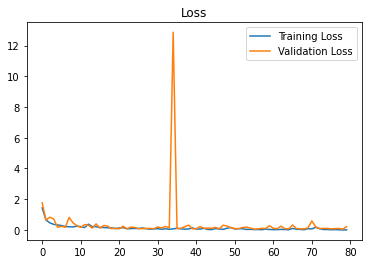

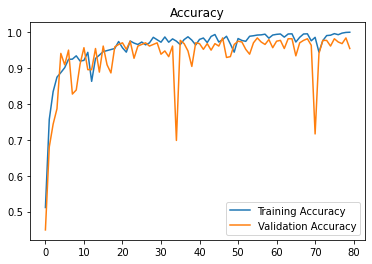

In [19]:
plot_metrics(history)

In [21]:
loss, acc = model.evaluate(x=X_test, y=y_test)

14/14 [==============================] - 4s 249ms/step - loss: 0.2762 - accuracy: 0.9659


In [23]:
print (f"Loss = {loss*100}")
print (f"Accuracy= {acc*100}")



Loss = 27.617353200912476
Accuracy= 96.59090638160706


In [28]:
print (f"Main Loss = {main_loss*100}")
print (f"Aux1 Loss = {aux1_loss*100}")
print (f"Aux2 Loss = {aux2_loss*100}")
print (f"Main Accuracy = {main_accuracy*100}")
print (f"Aux1 accuracy = {aux1_accuracy*100}")
print (f"Aux2 Accuracy = {aux2_accuracy*100}")

Main Loss = 47.96578288078308
Aux1 Loss = 20.075584948062897
Aux2 Loss = 29.081469774246216
Main Accuracy = 97.27272987365723
Aux1 accuracy = 97.50000238418579
Aux2 Accuracy = 97.27272987365723


In [24]:
loss,accuracy = model.evaluate(x=X_val, y=y_val)
print (f"Loss = {loss*100}")

print (f"Accuracy = {accuracy*100}")


14/14 [==============================] - 5s 338ms/step - loss: 0.2133 - accuracy: 0.9546
Loss = 21.334221959114075
Accuracy = 95.46485543251038


In [14]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16()

553467904/553467096 [==============================] - 63s 0us/step


In [15]:
print(model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [17]:
start_time = time.time()

vgg16_model.fit(x=X_train, y=y_train, batch_size=16, epochs=80, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/80
129/129 [==============================] - 1479s 11s/step - loss: 1.1049 - accuracy: 0.3190 - val_loss: 1.1017 - val_accuracy: 0.3243
Epoch 2/80
129/129 [==============================] - 1392s 11s/step - loss: 1.1017 - accuracy: 0.3298 - val_loss: 1.0992 - val_accuracy: 0.3243
Epoch 3/80
129/129 [==============================] - 1390s 11s/step - loss: 1.1030 - accuracy: 0.3317 - val_loss: 1.1093 - val_accuracy: 0.3243
Epoch 4/80
129/129 [==============================] - 1387s 11s/step - loss: 1.1030 - accuracy: 0.3210 - val_loss: 1.1031 - val_accuracy: 0.3243
Epoch 5/80
129/129 [==============================] - 1389s 11s/step - loss: 1.1013 - accuracy: 0.3322 - val_loss: 1.0990 - val_accuracy: 0.3379
Epoch 6/80
129/129 [==============================] - 1388s 11s/step - loss: 1.0999 - accuracy: 0.3415 - val_loss: 1.1063 - val_accuracy: 0.3243
Epoch 7/80
129/129 [==============================] - 1387s 11s/step - loss: 1.1024 - accuracy: 0.3234 - val_loss: 1.1007 - val_ac

KeyboardInterrupt: 